$$\text{\Huge{Natural Language Processing (NLP)}}$$

**Dataset**: [Kaggle](https://www.kaggle.com/datasets/zhangjuefei/death-metal?datasetId=649)

> Metal-Archives.com (MA for short) is an encyclopedia website which includes information of nearly all heavy bands and albums on the earth. This information is collected and submitted by metalheads from all around the world. This dataset includes all "death metal" bands and albums on MA (by Nov. 2016).

**What question are you going to address?**

- Is it possible to create a text model to predict if an album review is positive or negative?
- Is there a difference in scoring between a model that considered word order vs. no word order?

**Define the problem as a supervised learning task, and how you will solve it using machine learning.**

- We are using supervised learning and binary classification, because we are predicting whether a review is positive or negative.
- We will be utilizing a two model setup - word order vs. no word order
- We will attempt to explore the problem using a pretrained model as well as using layer/model concatenation

$$\text{\Huge{Setup}}$$

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import scienceplots
import seaborn as sns
import shutil
import sklearn as sk
import tensorflow as tf
import warnings

from decimal import Decimal
from io import BytesIO
from IPython.display import display, HTML, Markdown
from nltk.corpus import stopwords
from pathlib import Path
from random import choice, sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from splitfolders import ratio
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    GlobalMaxPooling1D,
    LSTM,
    Rescaling,
    TextVectorization
)
from tensorflow.keras.initializers import Constant
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L1L2, L2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model, text_dataset_from_directory
from urllib.request import urlretrieve
from wordcloud import WordCloud, STOPWORDS
from zipfile import ZipFile

In [2]:
plt.style.use('science')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlepad'] = 15 
plt.rcParams['axes.labelpad'] = 15
plt.rcParams['legend.title_fontsize'] = 16
plt.rcParams['legend.fontsize'] = 12

In [3]:
CASES = {
    'est': 'Estimated',
    'max': 'Maximum',
    'min': 'Minimum',
    'param': ''
}

def column_to_title(column):
    column = column.replace('_', ' ').title()

    for word, replacement in cases.items():
        column = column.replace(word.title(), replacement)

    return column

In [4]:
def display_deep_score(loss: float, accuracy: float) -> pd.DataFrame:        
        score = {}

        score['Loss'] = loss
        score['Accuracy'] = accuracy

        data = score.items()
        columns = ['Metric', 'Score']

        return pd.DataFrame(data=data, columns=columns)

In [5]:
def display_album_review_percentage(dataset: pd.DataFrame) -> pd.DataFrame:        
    total = len(dataset)
    
    report = []
    
    for reviews in range(1, 11):
        template = {}
    
        count = (
            dataset
            .album
            .value_counts()
            .where(
                dataset
                .album
                .value_counts() == reviews
            )
            .sum()
        )
    
        row, _ = dataset.shape
        percentage = (count / row) * 100
        percentage = round(percentage, 2)
        percentage = f"{percentage}%"
    
        template['reviews'] = reviews
        template['percentage'] = percentage
        report.append(template)

    return pd.DataFrame(report)

In [6]:
def get_word_list(dataframe, column):
    words = []

    word = (
        dataframe[column]
        .str
        .split(expand=True)
        .stack()
    )

    (
        word
        .replace('[^a-zA-Z0-9]', '')
        .loc[word.str.len() > 2]
        .groupby(level=0)
        .apply(' '.join)
        .str
        .lower()
        .str
        .split()
        .apply(words.extend)
    )

    return ' '.join(words)

$$\text{\Huge{Data understanding}}$$

In [7]:
cwd = Path.cwd()

In [8]:
# The folder for the training/testing/validation split
dataset = cwd.joinpath('dataset')

# Preprocessing
preprocessing = dataset.joinpath('preprocessing')
preprocessing_positive = preprocessing.joinpath('positive')
preprocessing_negative = preprocessing.joinpath('negative')

preprocessing_positive.mkdir(parents=True, exist_ok=True)
preprocessing_negative.mkdir(parents=True, exist_ok=True)

```
project
│    archive.zip
└────metal
│    │    albums.csv
│    │    bands.csv
│    │    reviews.csv



```

In [9]:
# The folder for each .csv file
metal = cwd.joinpath('metal')
metal.mkdir(parents=True, exist_ok=True)

In [10]:
is_metal_empty = not any(
    metal.iterdir()
)

# Extract the .zip file if the metal folder doesn't exist or is empty
if not metal.is_dir() or is_metal_empty:
    archive = cwd.joinpath('archive.zip')

    file = ZipFile(archive, 'r')
    file.extractall(metal)
    file.close()

In [11]:
album = metal.joinpath('albums.csv')
band = metal.joinpath('bands.csv')
review = metal.joinpath('reviews.csv')

In [12]:
df_album = pd.read_csv(
    album,
    engine='python',
    na_values=['N/A']
)

In [13]:
df_band = pd.read_csv(
    band,
    engine='python',
    na_values=['N/A']
)

We will use `df_review` the most, but the previous information will be good to provide context near the end of the project

In [14]:
df_review = pd.read_csv(
    review,
    engine='python',
    na_values=['N/A']
)

In [15]:
print(df_album.shape)
print(df_band.shape)
print(df_review.shape)

(28069, 4)
(37723, 8)
(21510, 5)


In [16]:
df_album.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28069 entries, 0 to 28068
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      28069 non-null  int64 
 1   band    28069 non-null  int64 
 2   title   28069 non-null  object
 3   year    28069 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 877.3+ KB


In [17]:
df_band.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37723 entries, 0 to 37722
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         37723 non-null  int64  
 1   name       37723 non-null  object 
 2   country    37723 non-null  object 
 3   status     37723 non-null  object 
 4   formed_in  33392 non-null  float64
 5   genre      37723 non-null  object 
 6   theme      20179 non-null  object 
 7   active     33796 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 2.3+ MB


In [18]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21510 entries, 0 to 21509
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       21510 non-null  int64  
 1   album    21510 non-null  int64  
 2   title    21510 non-null  object 
 3   score    21510 non-null  float64
 4   content  21510 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 840.4+ KB


In [19]:
df_review.head(5)

,id,album,title,score,content
0,1,4,The Killer Count Just Keeps Rising,0.88,When I first threw this on I really didnt know...
1,2,5,A gem of heterogeneous death metal...,0.96,Several years ago I bought from a band member|...
2,3,8,Fantasic| if mostly for its influences,0.83,What a wonderful release this is. ‘Vox Fatum’ ...
3,4,45,A rare| lost hidden gem,0.80,Picture this: crushing| brutal death metal| wi...
4,5,54,Pure| but flayed and covered in soot,0.92,Abhordium's When Depravity Incarnates is an ex...


The longest review is 20732 characters

In [20]:
df_review.content.str.len().max()

20732

We determined a score above 0.50 is a positive review and a score below 0.50 is a negative review

In [21]:
df_positive = df_review.copy()
df_positive = df_positive[df_positive.score >= 0.50]
df_positive['occurrence'] = df_positive.groupby('album').cumcount() + 1

In [22]:
df_positive.shape

(19625, 6)

Album #24752 received the most positive feedback among 19625 positively reviewed albums.

In [23]:
df_positive.album.value_counts()

album
24752    29
10727    27
18338    26
27938    26
5714     24
         ..
12099     1
12098     1
12090     1
12082     1
28067     1
Name: count, Length: 7563, dtype: int64

Each positively reviewed album in this dataset tended to receive a single review

In [24]:
display_album_review_percentage(df_positive)

,reviews,percentage
0,1,20.19%
1,2,14.41%
2,3,10.2%
3,4,9.07%
4,5,7.31%
5,6,5.59%
6,7,5.17%
7,8,3.14%
8,9,3.35%
9,10,2.8%


In [25]:
df_negative = df_review.copy()
df_negative = df_negative[df_negative.score < 0.50]
df_negative['occurrence'] = df_negative.groupby('album').cumcount() + 1

In [26]:
df_negative.shape

(1885, 6)

Album #25019 received the most negative feedback among 1885 negatively reviewed albums.

In [27]:
df_negative.album.value_counts()

album
25019    23
3397     21
25609    14
27110    11
27114    11
         ..
17517     1
17550     1
17583     1
17721     1
28013     1
Name: count, Length: 1221, dtype: int64

Each negatively reviewed album in this dataset tended to receive *just* a single review, and the distribution is much smaller than the positively reviewed

In [28]:
display_album_review_percentage(df_negative)

,reviews,percentage
0,1,48.65%
1,2,17.82%
2,3,9.39%
3,4,6.79%
4,5,4.51%
5,6,3.5%
6,7,1.86%
7,8,1.27%
8,9,1.43%
9,10,0.53%


$$\text{\Huge{Data wrangling / preprocessing}}$$

We count the amount of reviews per album for the sake of naming. The filename will be formatted as such: "{id}\_{album}\_{occurrence}.txt" so in the future we can split the filename on the underscore, and do a lookup of said review/album/band for further context.

In [29]:
is_positive_preprocessing_empty = not any(
    preprocessing_positive.iterdir()
)

if is_positive_preprocessing_empty:
    for index, row in df_positive.iterrows():
        filename = f"{row.id}_{row.album}_{row.occurrence}.txt"
        path = preprocessing_positive.joinpath(filename)

        with path.open('w', encoding='utf-8') as handle:
            text = row.content.replace('|', ',')
            handle.write(text)

In [30]:
is_negative_preprocessing_empty = not any(
    preprocessing_negative.iterdir()
)

if is_negative_preprocessing_empty:
    for index, row in df_negative.iterrows():
        filename = f"{row.id}_{row.album}_{row.occurrence}.txt"
        path = preprocessing_negative.joinpath(filename)

        with path.open('w', encoding='utf-8') as handle:
            text = row.content.replace('|', ',')
            handle.write(text)

We look for the existence of file(s) and/or folder(s), so we don't reprocess the dataset each time the script is run

In [31]:
processed = (
    dataset.joinpath('training').exists() and
    dataset.joinpath('testing').exists() and
    dataset.joinpath('validation').exists()
)

if not processed:
    ratio(
        preprocessing,
        output=dataset,
        ratio=(0.70, 0.15, 0.15),
        group_prefix=None,
        move=False
    )

Rename the directories after `splitfolders` divided the dataset into training, testing and validation

In [32]:
processed = (
    dataset.joinpath('train').exists() and
    dataset.joinpath('test').exists() and
    dataset.joinpath('val').exists()
)

if processed:
    dataset.joinpath('train').rename(
        dataset.joinpath('training')
    )

    dataset.joinpath('test').rename(
        dataset.joinpath('testing')
    )

    dataset.joinpath('val').rename(
        dataset.joinpath('validation')
    )

This is the structure of our training, testing and validation split after reorganizing and renaming:

```
project
└────dataset
│    └────preprocessing
│         └────positive
│              │    *.txt
│         └────negative
│              │    *.txt
│    └────testing
│         └────positive
│              │    *.txt
│         └────negative
│              │    *.txt
│    └────training
│         └────positive
│              │    *.txt
│         └────negative
│              │    *.txt
│    └────validation
│         └────positive
│              │    *.txt
│         └────negative
│              │    *.txt



```

$$\text{\Huge{Word cloud}}$$

In [33]:
home = Path(
    os.getenv('APPDATA')
)

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brayden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
stopwords = set(
    stopwords.words('english')
)

In [35]:
words = get_word_list(df_review, 'content')

The word count is **62,442,202** (*excluding those that are less than 3 characters*) from all reviews

In [36]:
length = len(words)
print(length)

62442202


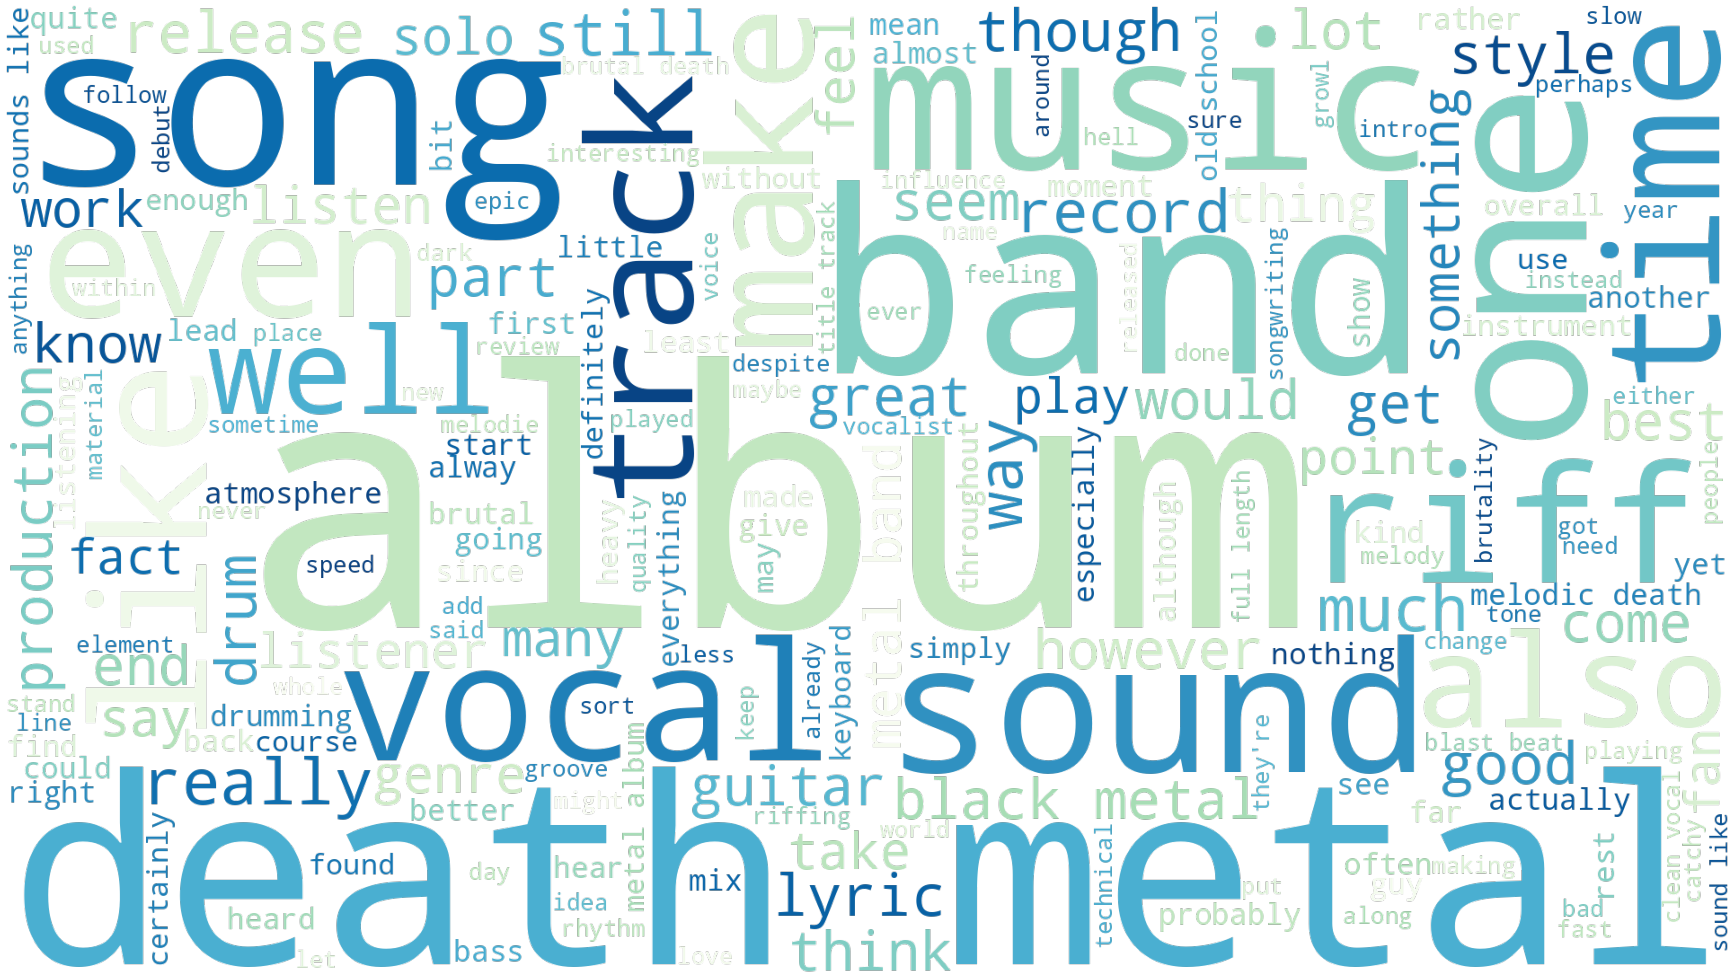

In [37]:
figsize = (30, 10)
fig, ax = plt.subplots(figsize=figsize)

rc = WordCloud(
    background_color=(0, 0, 0, 0),
    colormap='GnBu',
    mode='RGBA',
    stopwords=stopwords,
    width=1920,
    height=1080
)

rc.generate(words)

plt.imshow(rc)

plt.axis('off')

plt.tight_layout()
plt.show()
plt.close()

Remove the reference to the review list and wordcloud

In [38]:
%xdel words
%xdel rc

In [39]:
words = get_word_list(df_positive, 'content')

The word count is **56,604,567** (*excluding those that are less than 3 characters*) from positive reviews

In [40]:
length = len(words)
print(length)

56604567


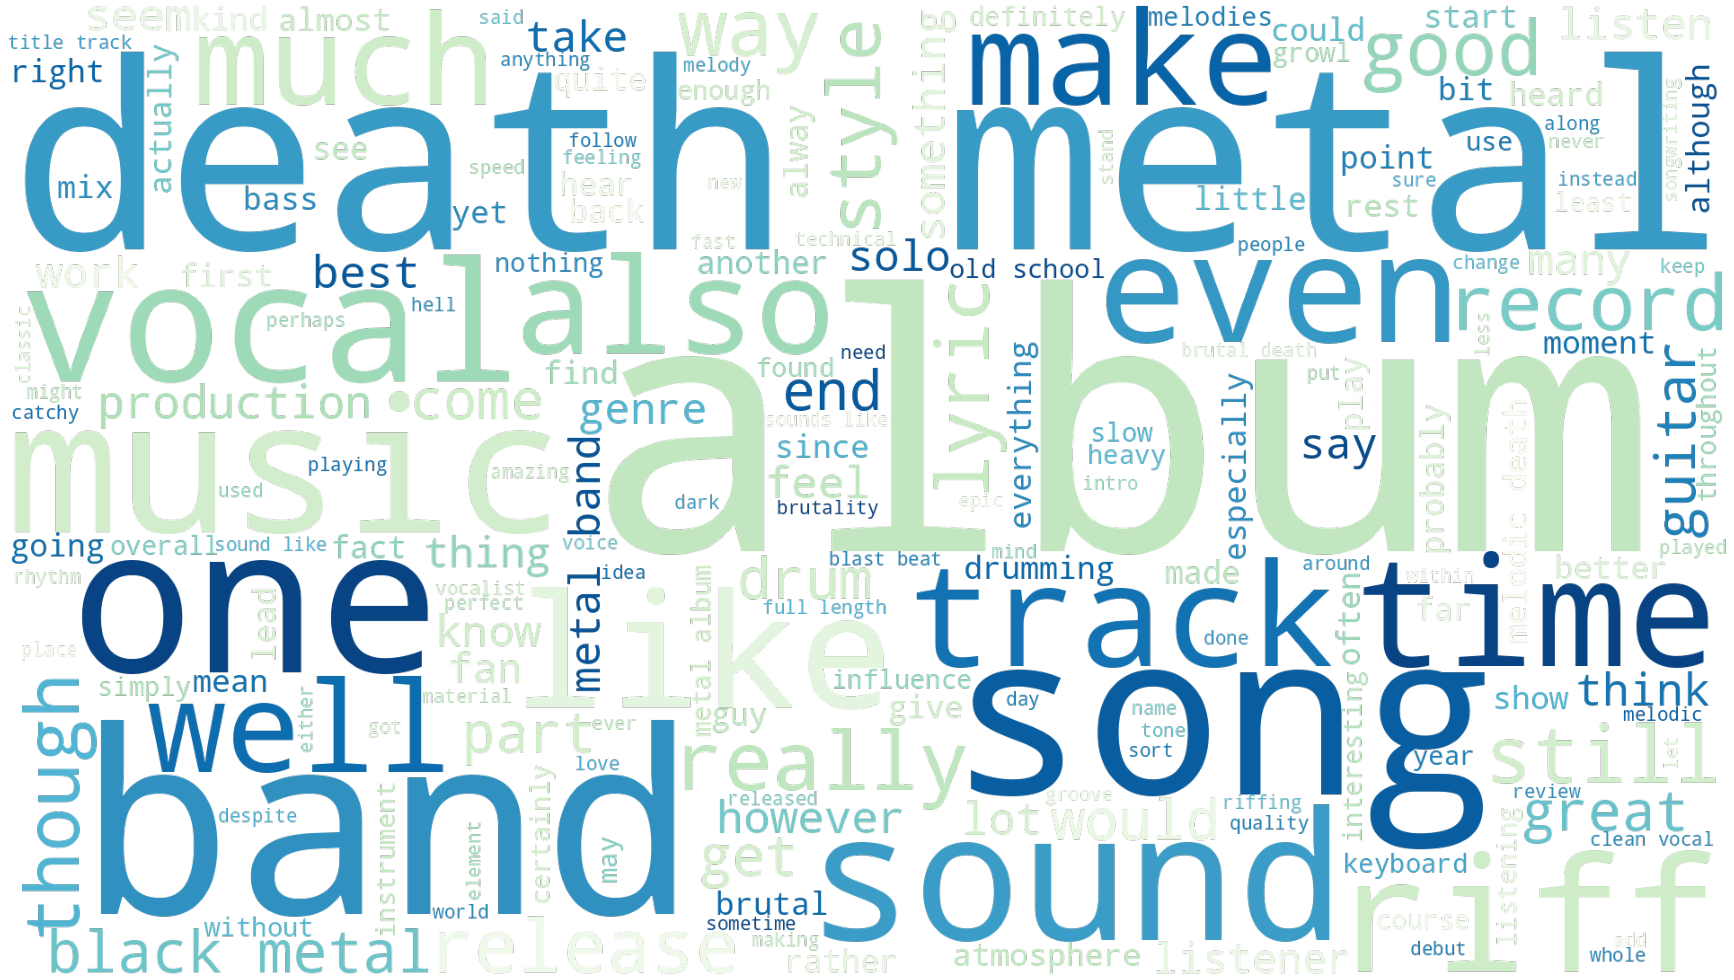

In [41]:
figsize = (30, 10)
fig, ax = plt.subplots(figsize=figsize)

pc = WordCloud(
    background_color=(0, 0, 0, 0),
    colormap='GnBu',
    mode='RGBA',
    stopwords=stopwords,
    width=1920,
    height=1080
)

pc.generate(words)

plt.imshow(pc)

plt.axis('off')

plt.tight_layout()
plt.show()
plt.close()

Remove the reference to the positive list and wordcloud

In [42]:
%xdel words
%xdel pc

In [43]:
words = get_word_list(df_negative, 'content')

The word count is **5,837,634** (*excluding those that are less than 3 characters*) from negative reviews

In [44]:
length = len(words)
print(length)

5837634


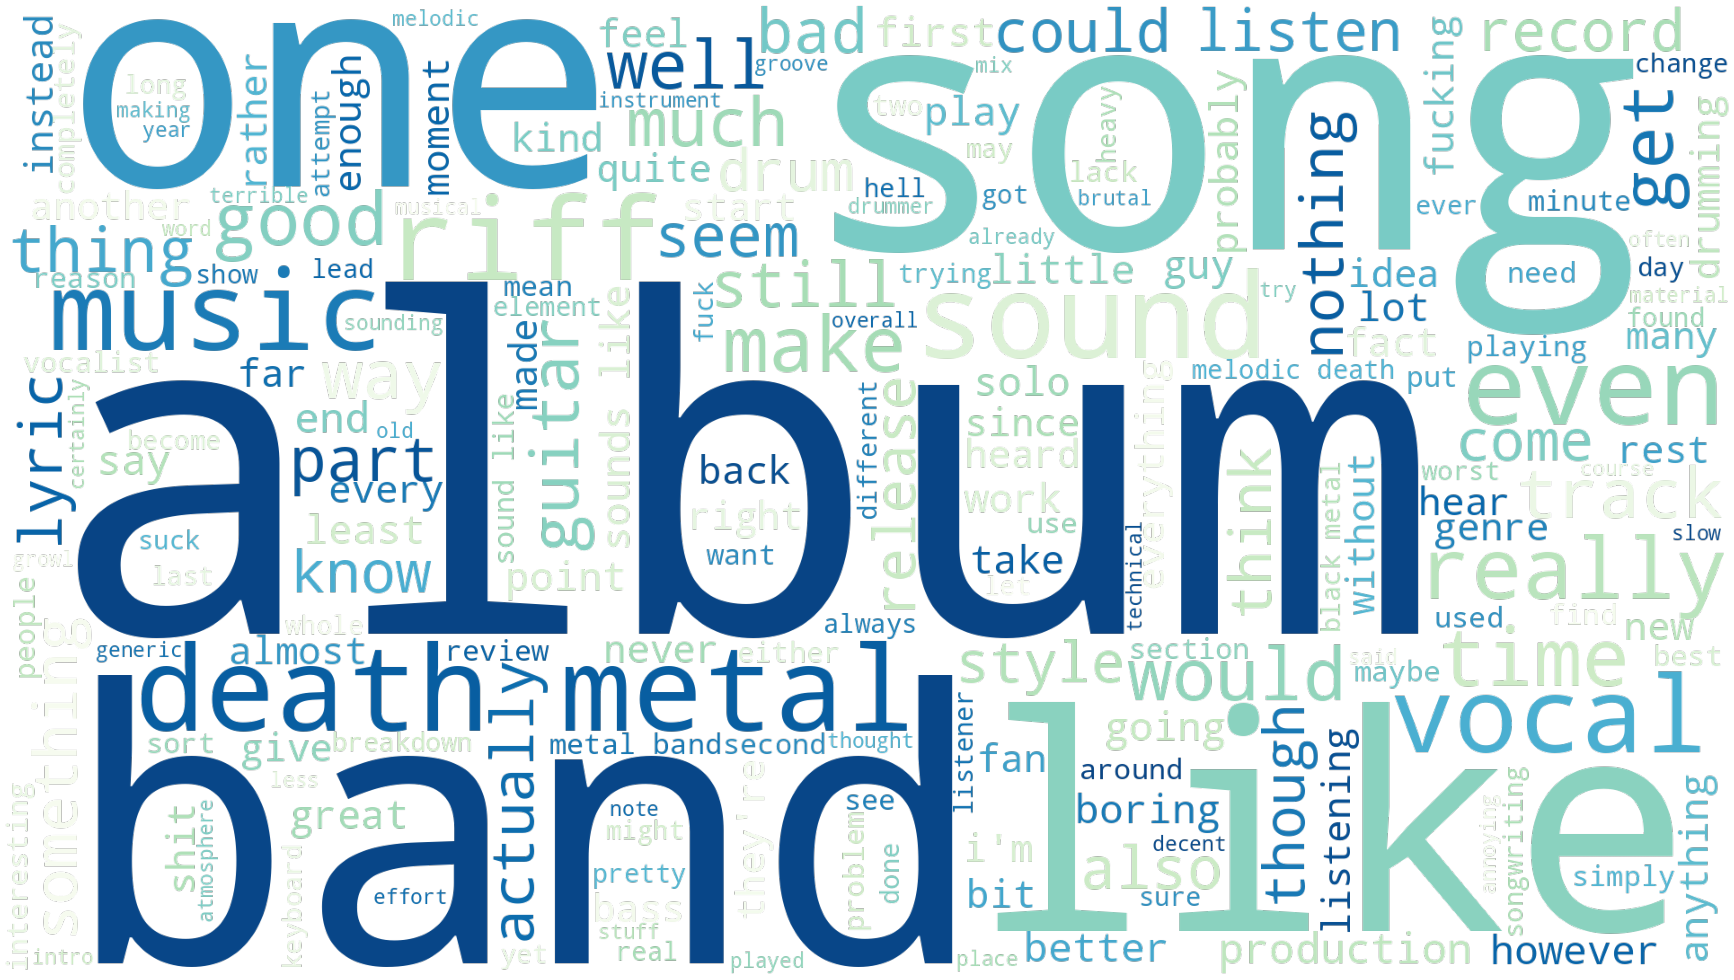

In [45]:
figsize = (30, 10)
fig, ax = plt.subplots(figsize=figsize)

nc = WordCloud(
    background_color=(0, 0, 0, 0),
    colormap='GnBu',
    mode='RGBA',
    stopwords=stopwords,
    width=1920,
    height=1080
)

nc.generate(words)

plt.imshow(nc)

plt.axis('off')

plt.tight_layout()
plt.show()
plt.close()

Remove the reference to the negative list and wordcloud

In [46]:
%xdel words
%xdel nc

$$\text{\Huge{Build a model}}$$

In [47]:
def encoding(text: str, label: str) -> tuple[str, str]:
    text = tf.strings.unicode_transcode(text, 'ISO-8859-1', 'UTF-8')
    return text, label

In [48]:
# Training
training = dataset.joinpath('training')
training_positive = training.joinpath('positive')
training_negative = training.joinpath('negative')

# Testing
testing = dataset.joinpath('testing')
testing_positive = testing.joinpath('positive')
testing_negative = testing.joinpath('negative')

# Validation
validation = dataset.joinpath('validation')
validation_positive = validation.joinpath('positive')
validation_negative = validation.joinpath('negative')

In [49]:
batch_size = 32

training_dataset = text_dataset_from_directory(
    training,
    batch_size=batch_size
)

testing_dataset = text_dataset_from_directory(
    testing,
    batch_size=batch_size
)

validation_dataset = text_dataset_from_directory(
    validation,
    batch_size=batch_size
)

training_dataset = training_dataset.map(encoding)
testing_dataset = testing_dataset.map(encoding)
validation_dataset = validation_dataset.map(encoding)

Found 1351 files belonging to 2 classes.
Found 292 files belonging to 2 classes.
Found 289 files belonging to 2 classes.


In [50]:
# Parameters
epochs = 30
max_tokens = 21000
output_mode = 'multi_hot'
shape = (1,)

$$\text{\Huge{No Word Order Model}}$$

In [51]:
text_vectorization = TextVectorization(
    ngrams=1,
    max_tokens=max_tokens,
    output_mode=output_mode
)

In [52]:
text_only_training = training_dataset.map(lambda x, y: x)
text_vectorization.adapt(text_only_training)

In [53]:
vocab = text_vectorization.get_vocabulary()
vocab[0:10]

['[UNK]', 'the', 'of', 'and', 'to', 'a', 'is', 'that', 'this', 'in']

In [54]:
inputs = Input(shape=shape, dtype='string')
vectorized = text_vectorization(inputs)

x = Dense(64, activation = 'relu')(vectorized)
x = BatchNormalization()(x)
x = Dropout(0.35)(x)

x = Dense(32, activation = 'relu')(vectorized)
x = BatchNormalization()(x)
x = Dropout(0.40)(x)

x = Dense(16, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

x = Dense(8, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)

outputs = Dense(1, activation='sigmoid')(x)

In [55]:
model_nw = Model(inputs=inputs, outputs=outputs)

In [56]:
model_nw.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [57]:
callbacks = [
    ModelCheckpoint(
        filepath='dm_1gram.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5
    )
]

In [58]:
history_nw = model_nw.fit(
    training_dataset.cache(),
    epochs=5,
    validation_data=validation_dataset.cache(),
    # callbacks=callbacks
)

Epoch 1/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5295 - loss: 0.9417 - val_accuracy: 0.9758 - val_loss: 0.5613
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5830 - loss: 0.8403 - val_accuracy: 0.9758 - val_loss: 0.4730
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6558 - loss: 0.7074 - val_accuracy: 0.9758 - val_loss: 0.4219
Epoch 4/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7347 - loss: 0.6126 - val_accuracy: 0.9758 - val_loss: 0.3873
Epoch 5/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7587 - loss: 0.6041 - val_accuracy: 0.9758 - val_loss: 0.3508


In [59]:
summary = model_nw.summary()
print(summary)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 21000)               │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │         672,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,018,565 (7.70 MB)

 Trainable params: 672,817 (2.57 MB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 1,345,636 (5.13 MB)

None


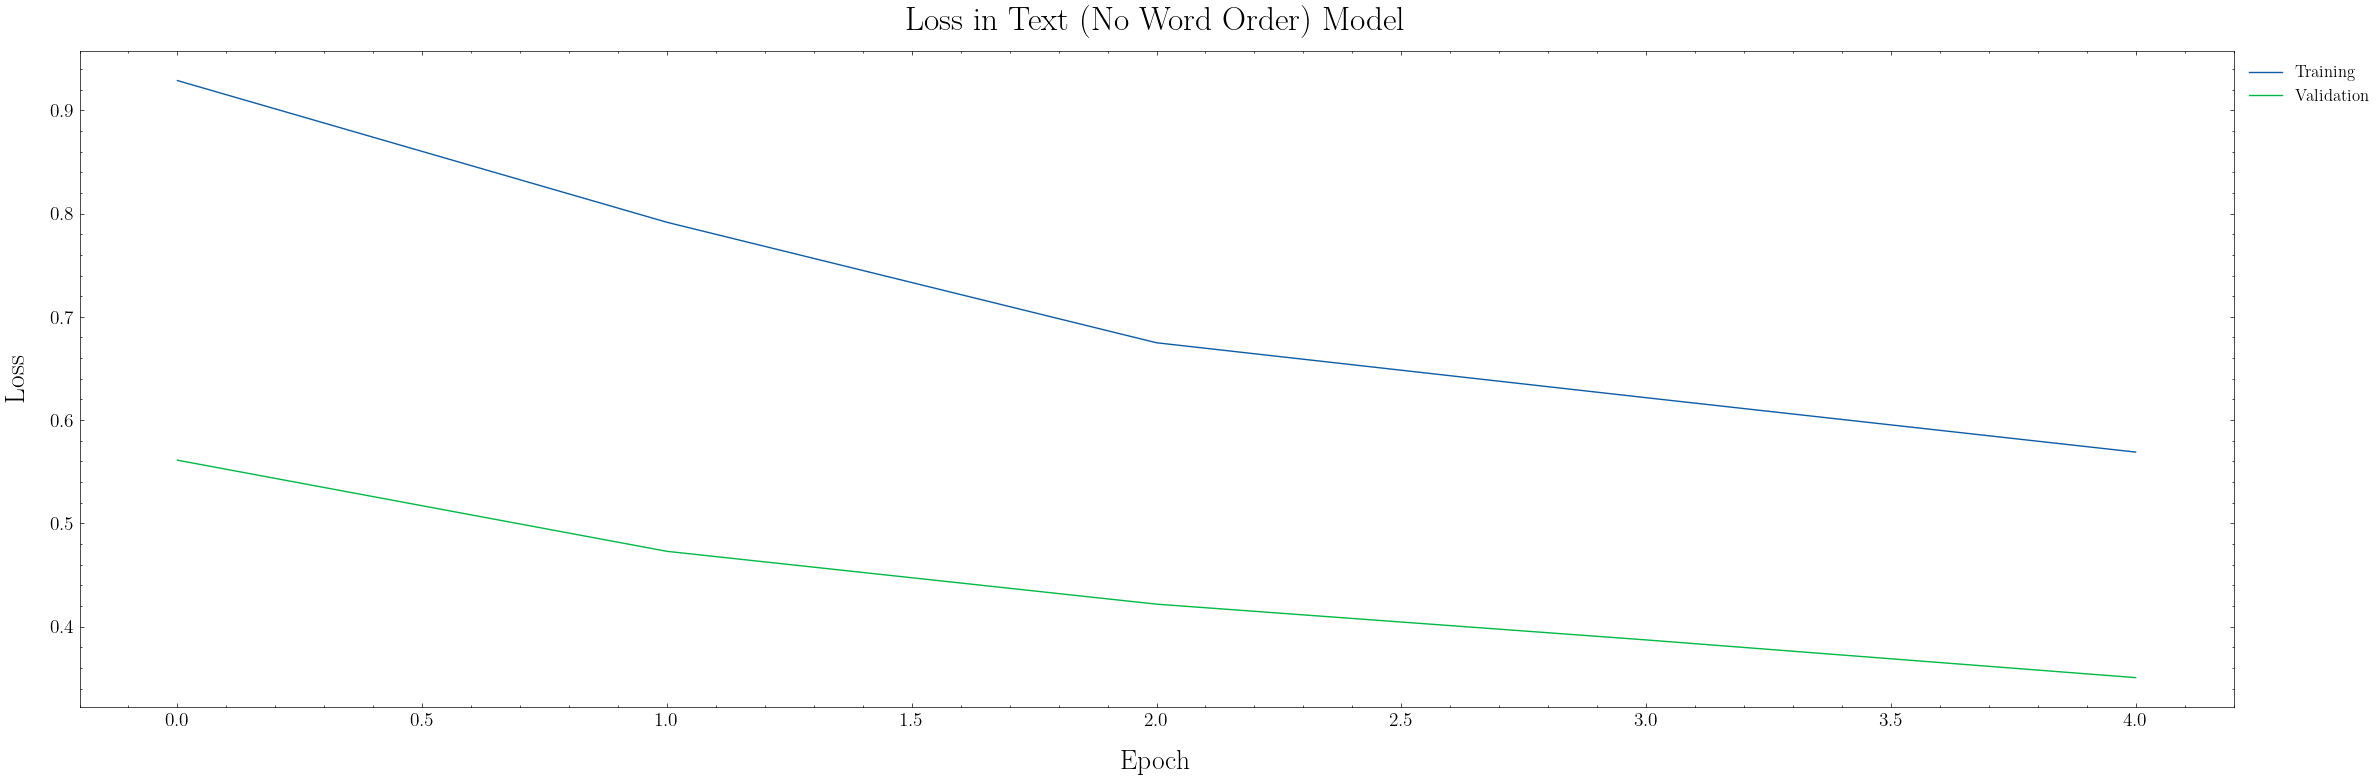

In [60]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history_nw.history['loss'],
    label='Training'
)

plt.plot(
    history_nw.history['val_loss'],
    label='Validation'
)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.set_title('Loss in Text (No Word Order) Model')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

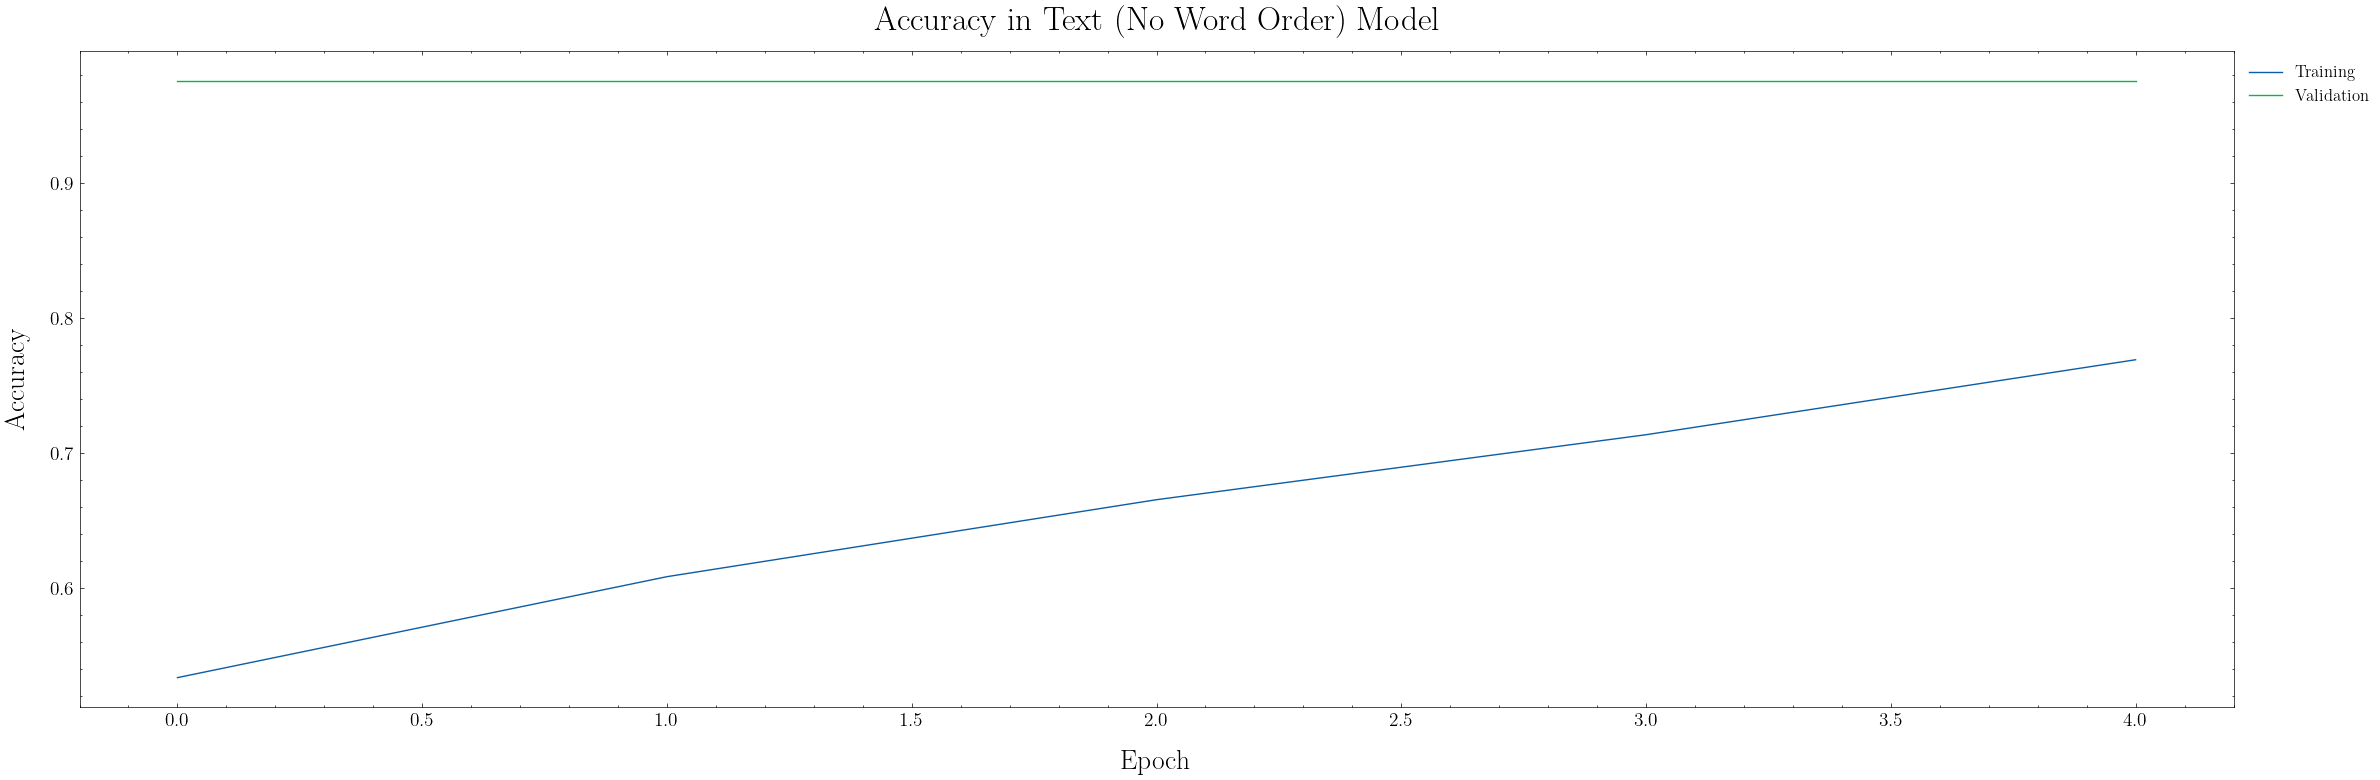

In [61]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history_nw.history['accuracy'],
    label='Training'
)

plt.plot(
    history_nw.history['val_accuracy'],
    label='Validation'
)

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.set_title('Accuracy in Text (No Word Order) Model')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

In [62]:
accuracy = history_nw.history['val_accuracy']
round(max(accuracy), 3)

0.976

In [63]:
loss, accuracy = model_nw.evaluate(training_dataset)
display_deep_score(loss, accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9821 - loss: 0.3623


,Metric,Score
0,Loss,0.367592
1,Accuracy,0.976314


In [64]:
loss, accuracy = model_nw.evaluate(testing_dataset)
display_deep_score(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9704 - loss: 0.3591 


,Metric,Score
0,Loss,0.356873
1,Accuracy,0.972603


In [65]:
loss, accuracy = model_nw.evaluate(validation_dataset)
display_deep_score(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9772 - loss: 0.3475 


,Metric,Score
0,Loss,0.350763
1,Accuracy,0.975779


$$\text{\Huge{Word Order Model}}$$

In [66]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=max_tokens,
    output_mode=output_mode
)

In [67]:
text_only_training_dataset = training_dataset.map(lambda x, y: x)
text_vectorization.adapt(text_only_training_dataset)

In [68]:
inputs = Input(shape=shape, dtype='string')
vectorized = text_vectorization(inputs)

x = Dense(32, activation = 'relu')(vectorized)
x = BatchNormalization()(x)
x = Dropout(0.40)(x)

x = Dense(16, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

x = Dense(8, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)

outputs = Dense(1, activation='sigmoid')(x)

In [69]:
model_wo = Model(inputs=inputs, outputs=outputs)

In [70]:
model_wo.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [71]:
callbacks = [
    ModelCheckpoint(
        filepath='dm_2gram.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5
    )
]

In [72]:
history_wo = model_wo.fit(
    training_dataset.cache(),
    epochs=6,
    validation_data=validation_dataset.cache(),
    # callbacks=callbacks
)

Epoch 1/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4826 - loss: 1.0160 - val_accuracy: 0.9412 - val_loss: 0.5575
Epoch 2/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5616 - loss: 0.8525 - val_accuracy: 0.9550 - val_loss: 0.4562
Epoch 3/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6248 - loss: 0.7226 - val_accuracy: 0.9758 - val_loss: 0.4250
Epoch 4/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6517 - loss: 0.6627 - val_accuracy: 0.9723 - val_loss: 0.4039
Epoch 5/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7122 - loss: 0.5860 - val_accuracy: 0.9758 - val_loss: 0.3512
Epoch 6/6
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7602 - loss: 0.5304 - val_accuracy: 0.9758 - val_loss: 0.3488


In [73]:
summary = model_wo.summary()
print(summary)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 21000)               │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │         672,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,018,565 (7.70 MB)

 Trainable params: 672,817 (2.57 MB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 1,345,636 (5.13 MB)

None


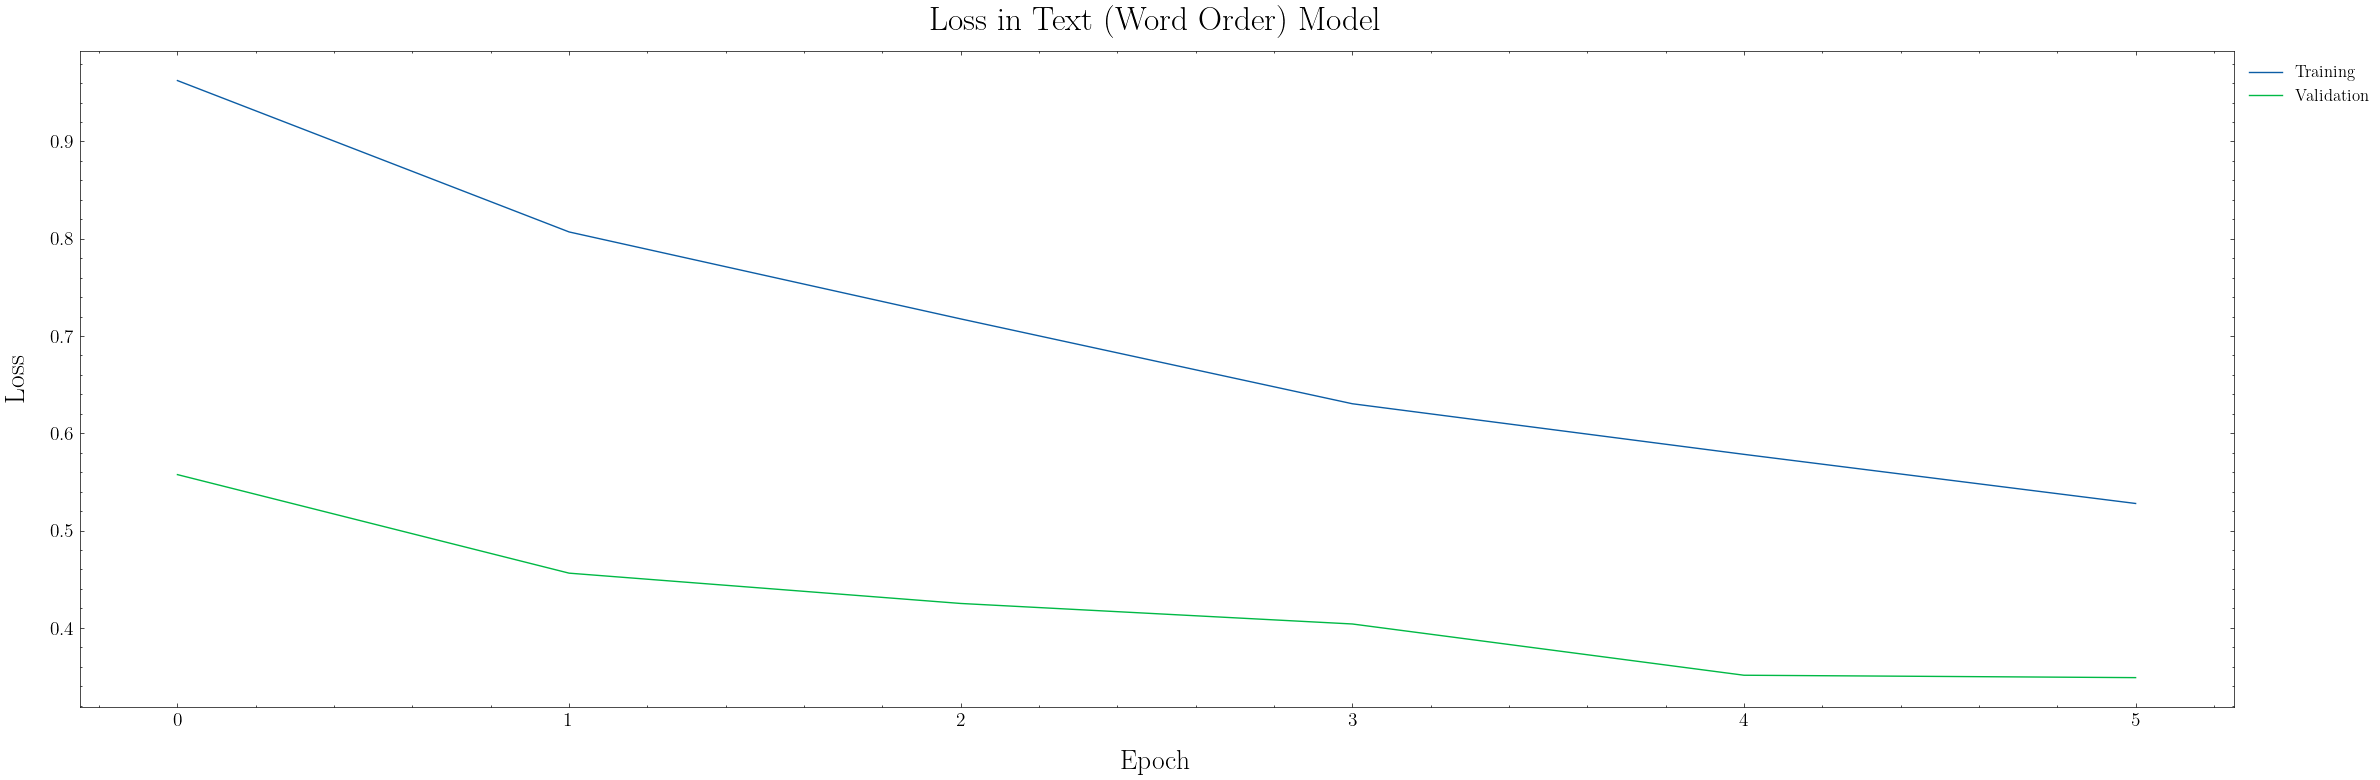

In [74]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history_wo.history['loss'],
    label='Training'
)

plt.plot(
    history_wo.history['val_loss'],
    label='Validation'
)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.set_title('Loss in Text (Word Order) Model')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

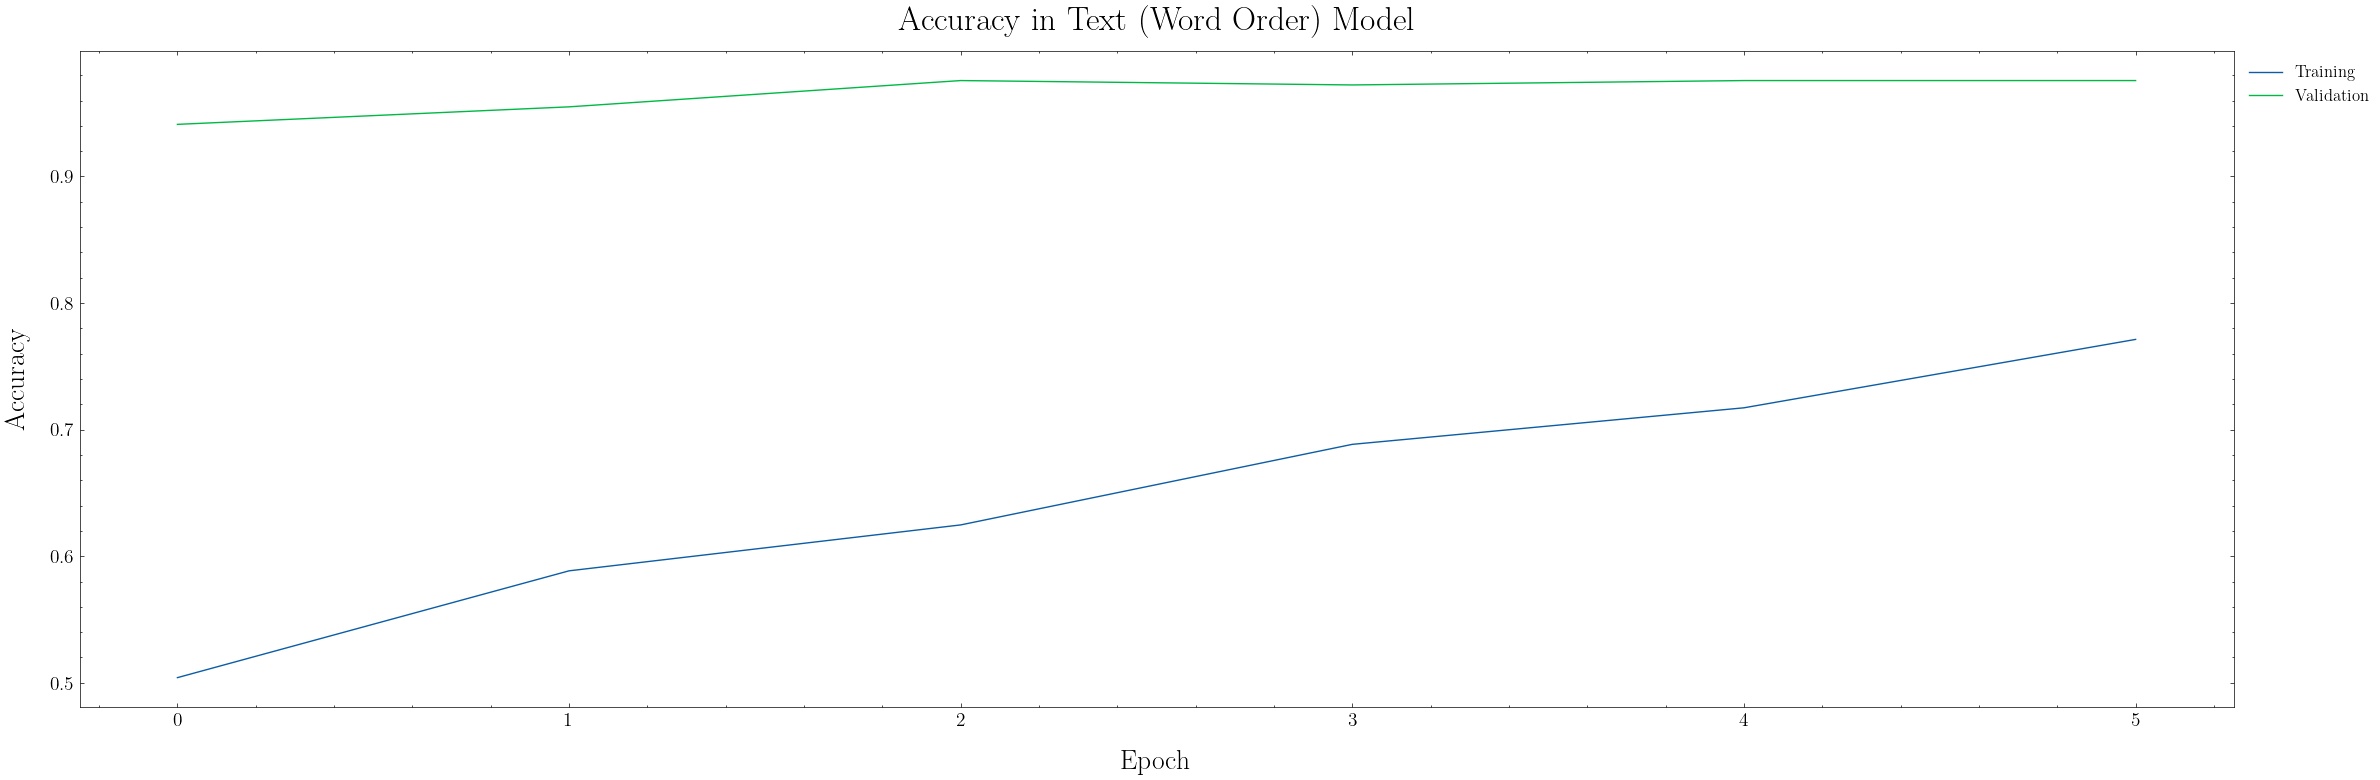

In [75]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history_wo.history['accuracy'],
    label='Training'
)

plt.plot(
    history_wo.history['val_accuracy'],
    label='Validation'
)

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.set_title('Accuracy in Text (Word Order) Model')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

In [76]:
accuracy = history_wo.history['val_accuracy']
round(max(accuracy), 3)

0.976

In [77]:
loss, accuracy = model_wo.evaluate(training_dataset)
display_deep_score(loss, accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9727 - loss: 0.3496


,Metric,Score
0,Loss,0.350282
1,Accuracy,0.971133


In [78]:
loss, accuracy = model_wo.evaluate(testing_dataset)
display_deep_score(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9659 - loss: 0.3608


,Metric,Score
0,Loss,0.351460
1,Accuracy,0.972603


In [79]:
loss, accuracy = model_wo.evaluate(validation_dataset)
display_deep_score(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9814 - loss: 0.3436


,Metric,Score
0,Loss,0.348761
1,Accuracy,0.975779


$$\text{\Huge{Pretrained Model}}$$

In [80]:
output_sequence_length = 600
output_mode = 'int'

text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode=output_mode,
    output_sequence_length=output_sequence_length
)

In [81]:
text_only_training_dataset = training_dataset.map(lambda x, y: x)
text_vectorization.adapt(text_only_training_dataset)

Download and unzip the GloVe algorithm if it doesn't exist

In [82]:
%%capture

archive = cwd.joinpath('glove.zip')

glove = cwd.joinpath('glove')
glove.mkdir(parents=True, exist_ok=True)

if not archive.is_file():
    url = 'https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip'
    urlretrieve(url, 'glove.zip')

    file = ZipFile(archive, 'r')
    file.extractall(glove)
    file.close()

In [83]:
# Point to the word embedding file
file = glove.joinpath('glove.6B.100d.txt')

# Build an index that maps each word to it's vector representation
embeddings_index = {}

with open(file, encoding='utf-8') as handle:
  for line in handle:
    # Get the word and the embedding values (coefs)
    word, coefs = line.split(maxsplit=1)

    # Separate all the embedding values
    coefs = np.fromstring(coefs, 'f', sep=' ')

    # Place the embedding values at the index of each word
    embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [84]:
embeddings_index['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [85]:
embedding_dim = 100

# Get a word index from our text_vectorization layer
vocabulary = text_vectorization.get_vocabulary()

word_index = dict(
    zip(
        vocabulary, range(
            len(vocabulary)
        )
    )
)

# Loop through the word index
embedding_matrix = np.zeros(
    (max_tokens, embedding_dim)
)

for word, i in word_index.items():
  # Get the word
  if i < max_tokens:
    embedding_vector = embeddings_index.get(word)

  # Get the embedding vector of that word
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [86]:
embeddings_initializer = Constant(embedding_matrix)

embedding_layer = Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=embeddings_initializer,
    mask_zero=True,
    trainable=False,
)

In [87]:
inputs = Input(shape=shape, dtype='string')
vectorized = text_vectorization(inputs)
embedded = embedding_layer(vectorized)

x = LSTM(32)(embedded)
x = BatchNormalization()(x)
x = Dropout(0.40)(x)

x = Dense(16, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

x = Dense(8, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)

outputs = Dense(1, activation='sigmoid')(x)

In [88]:
model_pretrained = Model(inputs=inputs, outputs=outputs)

In [89]:
model_pretrained.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [90]:
callbacks = [
    ModelCheckpoint(
        filepath='dm_pretrained.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5
    )
]

In [91]:
history_pretrained = model_pretrained.fit(
    training_dataset.cache(),
    epochs=5,
    validation_data=validation_dataset.cache(),
    # callbacks=callbacks
)

Epoch 1/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.4771 - loss: 1.1182 - val_accuracy: 0.9273 - val_loss: 0.5977
Epoch 2/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5229 - loss: 0.9132 - val_accuracy: 0.9758 - val_loss: 0.5557
Epoch 3/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6007 - loss: 0.7487 - val_accuracy: 0.9758 - val_loss: 0.5444
Epoch 4/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.6478 - loss: 0.6629 - val_accuracy: 0.9758 - val_loss: 0.5088
Epoch 5/5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.7092 - loss: 0.5749 - val_accuracy: 0.9758 - val_loss: 0.4465


In [92]:
summary = model_pretrained.summary()
print(summary)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape          ┃       Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1)             │             0 │ -                      │
│ (InputLayer)              │                       │               │                        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ text_vectorization_2      │ (None, 600)           │             0 │ input_layer_2[0][0]    │
│ (TextVectorization)       │                       │               │                        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 600, 100)      │     2,100,000 │ text_vectorization_2[… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 600)           │             0 │ text_vectorization_2[… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 32)            │        17,024 │ embedding[0][0],       │
│                           │                       │               │ not_equal[0][0]        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 32)            │           128 │ lstm[0][0]             │
│ (BatchNormalization)      │                       │               │                        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 32)            │             0 │ batch_normalization_7… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 16)            │           528 │ dropout_7[0][0]        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 16)            │            64 │ dense_9[0][0]          │
│ (BatchNormalization)      │                       │               │                        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 16)            │             0 │ batch_normalization_8… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 8)             │           136 │ dropout_8[0][0]        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 8)             │            32 │ dense_10[0][0]         │
│ (BatchNormalization)      │                       │               │                        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 8)             │             0 │ batch_normalization_9… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)             │             9 │ dropout_9[0][0]        │
└───────────────────────────┴───────────────────────┴───────────────┴────────────────────────┘

 Total params: 2,153,541 (8.22 MB)

 Trainable params: 17,809 (69.57 KB)

 Non-trainable params: 2,100,112 (8.01 MB)

 Optimizer params: 35,620 (139.14 KB)

None


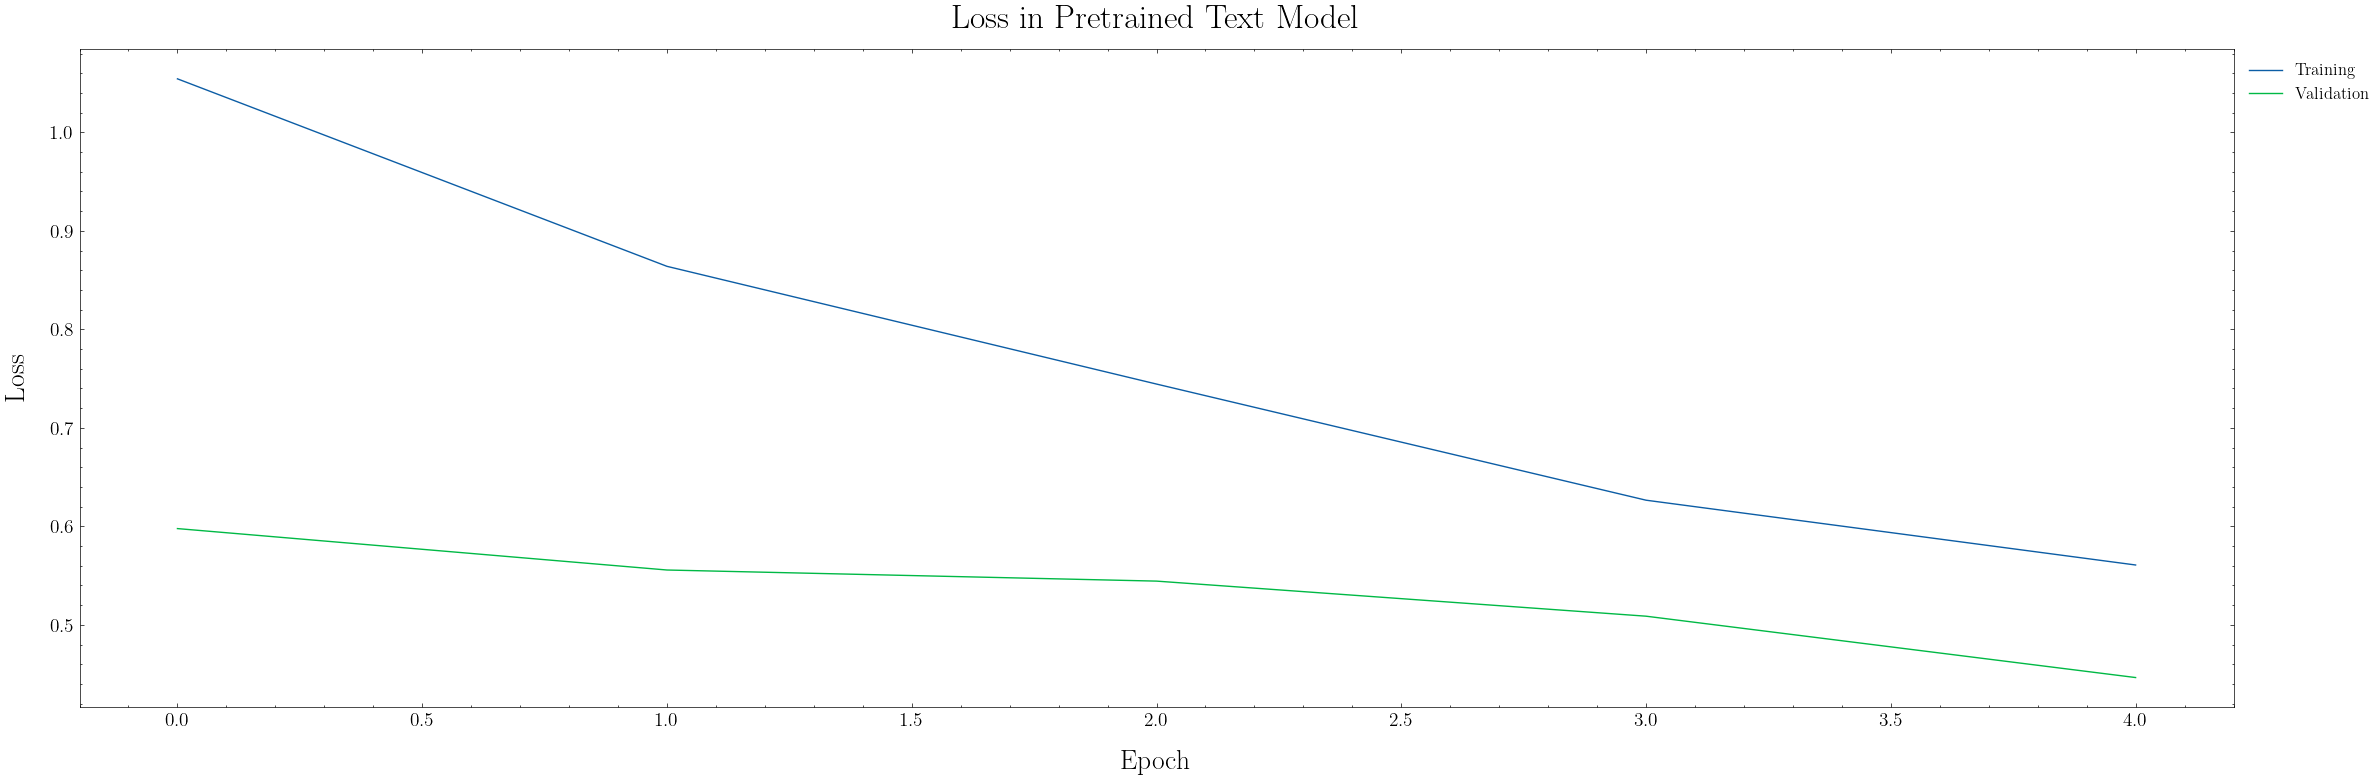

In [93]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history_pretrained.history['loss'],
    label='Training'
)

plt.plot(
    history_pretrained.history['val_loss'],
    label='Validation'
)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.set_title('Loss in Pretrained Text Model')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

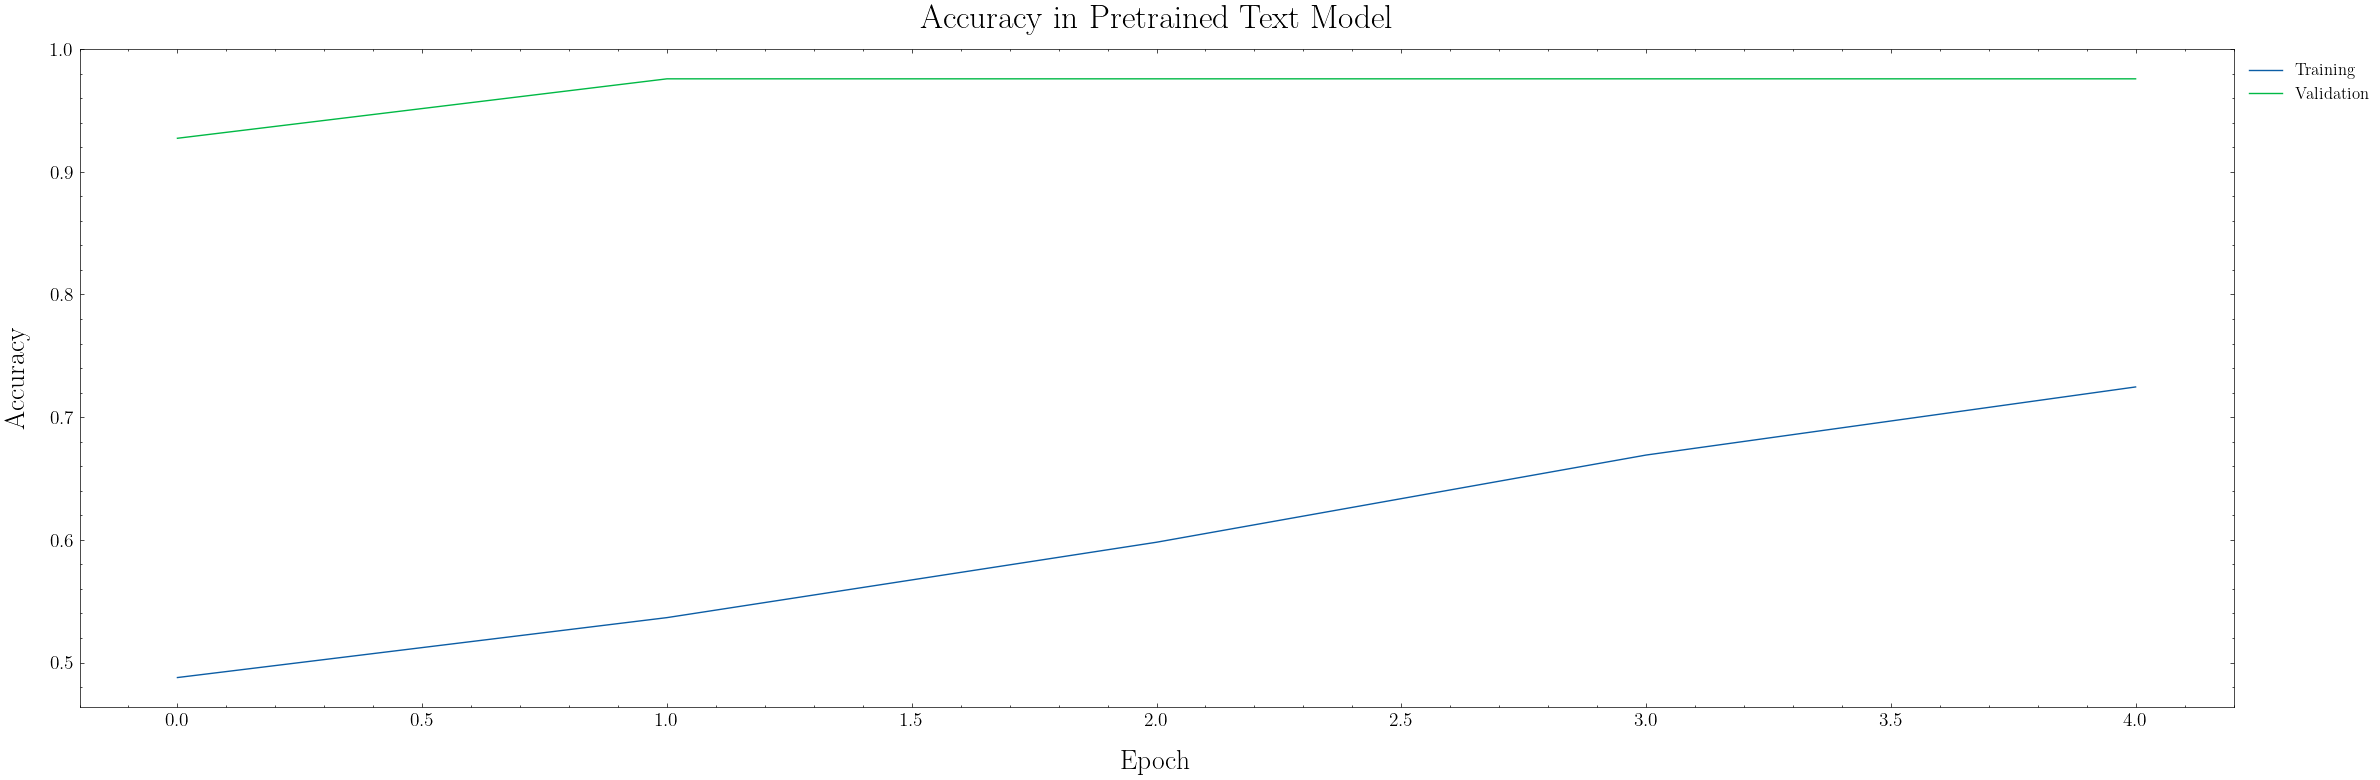

In [94]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history_pretrained.history['accuracy'],
    label='Training'
)

plt.plot(
    history_pretrained.history['val_accuracy'],
    label='Validation'
)

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.set_title('Accuracy in Pretrained Text Model')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

In [95]:
accuracy = history_pretrained.history['val_accuracy']
round(max(accuracy), 3)

0.976

In [96]:
loss, accuracy = model_pretrained.evaluate(training_dataset)
display_deep_score(loss, accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9821 - loss: 0.4401


,Metric,Score
0,Loss,0.443453
1,Accuracy,0.976314


In [97]:
loss, accuracy = model_pretrained.evaluate(testing_dataset)
display_deep_score(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9668 - loss: 0.4496


,Metric,Score
0,Loss,0.447381
1,Accuracy,0.972603


In [98]:
loss, accuracy = model_pretrained.evaluate(validation_dataset)
display_deep_score(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9787 - loss: 0.4442


,Metric,Score
0,Loss,0.446505
1,Accuracy,0.975779


- We used the training/validation accuracy and loss plot for each model to guide us in adjusting the layers and parameters.
- We noticed overfitting as soon as we started. In order to combat it, we used `BatchNormalization` and `Dropout`, which helped immensely
    - Before `BatchNormalization` and `Dropout`, our validation loss would spike and rise after each epoch, but our training loss would decrease
    - After `BatchNormalization` and `Dropout`, our validation loss would follow the same trend as our training loss, and decrease over time
- We observed no gain from a larger model - the accuracy and loss would fluctuate, but never improve beyond that of a simpler model
- As always, we tried to reference the information from the lectures and researched tutorials/examples from the internet
- After experimenting and tuning the parameters of the pretrained model and concatenation model, we noticed each model was relatively large
    - As a result, we noticed each model would overfit quickly
    - We assumed the imbalance in our dataset played a role in the size of our model

- We used a `Dense` layer, because it is the most common layer, and we had success in keeping our model simple
- We used `BatchNormalization` and `Dropout` to combat overfitting

- We began by creating a small model, and increased the size of each layer to get a sense of how our model would perform
- We found using a smaller model, and sorting the layer size in descending order seemed to yield the best model (in terms of accuracy and loss)
- We noticed that a larger model had the same predictive ability as the smaller model
    - For the sake of explainability, we chose to keep the model architecture smaller

- We referred to the "Architectural rules-of-thumb" slide from the lecture, which served as our guide for organizing the layers.
- We also referred to Dr. Bonnell's examples, in regards to how the layers were organized.

- Our goal was to identify if an album review was positive or negative, so we used `1` as our layer size and `sigmoid` as an activation function due to the nature of our problem.
    - This was a binary classification problem

$$\text{\Huge{Concatenation Model}}$$

In [99]:
df_concatenation = df_review.copy()
df_concatenation.loc[df_concatenation['score'] >= 0.50, 'score'] = 1
df_concatenation.loc[df_concatenation['score'] < 0.50, 'score'] = 0

In [100]:
df_concatenation.score.value_counts()

score
1.0    19625
0.0     1885
Name: count, dtype: int64

In [101]:
X_title = df_concatenation.title
X_content = df_concatenation.content
y = df_concatenation.score

In [102]:
df_concatenation

,id,album,title,score,content
0,1,4,The Killer Count Just Keeps Rising,1.0,When I first threw this on I really didnt know...
1,2,5,A gem of heterogeneous death metal...,1.0,Several years ago I bought from a band member|...
2,3,8,Fantasic| if mostly for its influences,1.0,What a wonderful release this is. ‘Vox Fatum’ ...
3,4,45,A rare| lost hidden gem,1.0,Picture this: crushing| brutal death metal| wi...
4,5,54,Pure| but flayed and covered in soot,1.0,Abhordium's When Depravity Incarnates is an ex...
...,...,...,...,...,...
21505,21506,28061,Delightful,1.0,What can a man accomplish in two years? Well| ...
21506,21507,28065,Frozen Mist White Noise Paranormal,1.0,Every now and then I stumble upon a really coo...
21507,21508,28065,Terrifying experimental death metal,1.0,Crawling out from Montoursville Pennysylvania ...
21508,21509,28066,Frozen Mist Anomalies Of The Forest,1.0,Deep in the mountain forest of Pennsylvania lu...


In [103]:
# Split into training and testing
X_train_title_all, X_test_title, X_train_content_all, X_test_content, y_train_all, y_test = train_test_split(
    X_title,
    X_content,
    y,
    test_size=0.20
)

# Split into training and validation
X_train_title, X_val_title, X_train_content, X_val_content, y_train, y_val = train_test_split(
    X_train_title_all,
    X_train_content_all,
    y_train_all,
    test_size=0.20
)

In [104]:
input_dim = max_tokens = 20000
output_mode = 'int'
output_sequence_length = 600

text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode=output_mode,
    output_sequence_length=output_sequence_length,
)

In [105]:
text = pd.concat(
    [X_train_title, X_train_content],
    axis=0
)

In [106]:
text_vectorization.adapt(text)

In [107]:
shape = shape=(1,)
dtype = 'string'
output_dim = 256
mask_zero = True

In [108]:
# Build the model for title
input_title = Input(shape=shape, dtype=dtype)
vectorized = text_vectorization(input_title)

embedded = Embedding(
    input_dim=input_dim,
    output_dim=output_dim,
    mask_zero=mask_zero
)(vectorized)

x = LSTM(16)(embedded)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

x = Dense(8, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)

x_title = Dense(8, activation='relu')(x)

In [109]:
# Build the model for content
input_content = Input(shape=shape, dtype=dtype)
vectorized = text_vectorization(input_content)

embedded = Embedding(
    input_dim=input_dim,
    output_dim=output_dim,
    mask_zero=mask_zero
)(vectorized)

x = LSTM(16)(embedded)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

x = Dense(8, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.50)(x)

x_content = Dense(8, activation='relu')(x)

In [110]:
combined = layers.concatenate(
    [x_title, x_content]
)

x = Dense(16, activation='relu')(combined)
outputs = Dense(1, activation='sigmoid')(x)

In [111]:
inputs = [input_title, input_content]

model_concatenation = Model(
    inputs=inputs,
    outputs=outputs
)

In [112]:
model_concatenation.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [113]:
callbacks = [
    ModelCheckpoint(
        filepath='model_concatenation.keras',
        monitor='val_loss',
        save_best_only=True
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5
    )
]

In [114]:
history_concatenation = model_concatenation.fit(
    [X_train_title, X_train_content],
    y_train,
    epochs=10,
    validation_data=(
        [X_val_title, X_val_content],
        y_val
    ),
    # callbacks=callbacks
)

Epoch 1/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 54s 120ms/step - accuracy: 0.8923 - loss: 0.3677 - val_accuracy: 0.9189 - val_loss: 0.3092
Epoch 2/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 51s 119ms/step - accuracy: 0.9085 - loss: 0.3038 - val_accuracy: 0.9189 - val_loss: 0.2662
Epoch 3/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - accuracy: 0.9093 - loss: 0.2669 - val_accuracy: 0.9192 - val_loss: 0.2344
Epoch 4/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - accuracy: 0.9148 - loss: 0.2170 - val_accuracy: 0.8919 - val_loss: 0.2547
Epoch 5/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - accuracy: 0.9331 - loss: 0.1643 - val_accuracy: 0.9253 - val_loss: 0.3519
Epoch 6/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - accuracy: 0.9485 - loss: 0.1250 - val_accuracy: 0.8713 - val_loss: 0.2780
Epoch 7/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 51s 117ms/step - accuracy: 0.9589 - loss: 0.1035 - val_accuracy: 0.9117 - val_loss: 0.2974
Epoch 8/10
431/431 ━━━━━━━━━━━━━━━━━━━━ 50s 117ms/step - accuracy: 0.9692 - loss: 0

In [115]:
summary = model_concatenation.summary()
print(summary)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape          ┃       Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 1)             │             0 │ -                      │
│ (InputLayer)              │                       │               │                        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ input_layer_4             │ (None, 1)             │             0 │ -                      │
│ (InputLayer)              │                       │               │                        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ text_vectorization_3      │ (None, 600)           │             0 │ input_layer_3[0][0],   │
│ (TextVectorization)       │                       │               │ input_layer_4[0][0]    │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 600, 256)      │     5,120,000 │ text_vectorization_3[… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 600)           │             0 │ text_vectorization_3[… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 600, 256)      │     5,120,000 │ text_vectorization_3[… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, 600)           │             0 │ text_vectorization_3[… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 16)            │        17,472 │ embedding_1[0][0],     │
│                           │                       │               │ not_equal_1[0][0]      │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 16)            │        17,472 │ embedding_2[0][0],     │
│                           │                       │               │ not_equal_2[0][0]      │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 16)            │            64 │ lstm_1[0][0]           │
│ (BatchNormalization)      │                       │               │                        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 16)            │            64 │ lstm_2[0][0]           │
│ (BatchNormalization)      │                       │               │                        │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 16)            │             0 │ batch_normalization_1… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 16)            │             0 │ batch_normalization_1… │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 8)             │           136 │ dropout_10[0][0]       │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 8)             │           136 │ dropout_12[0][0]       │
├───────────────────────────┼───────────────────────┼───────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 8)             │            32 │ dense_12[0][0]         │
│ (BatchNormalization)      │                       │               │                        │
├─────────

 Total params: 30,827,333 (117.60 MB)

 Trainable params: 10,275,745 (39.20 MB)

 Non-trainable params: 96 (384.00 B)

 Optimizer params: 20,551,492 (78.40 MB)

None


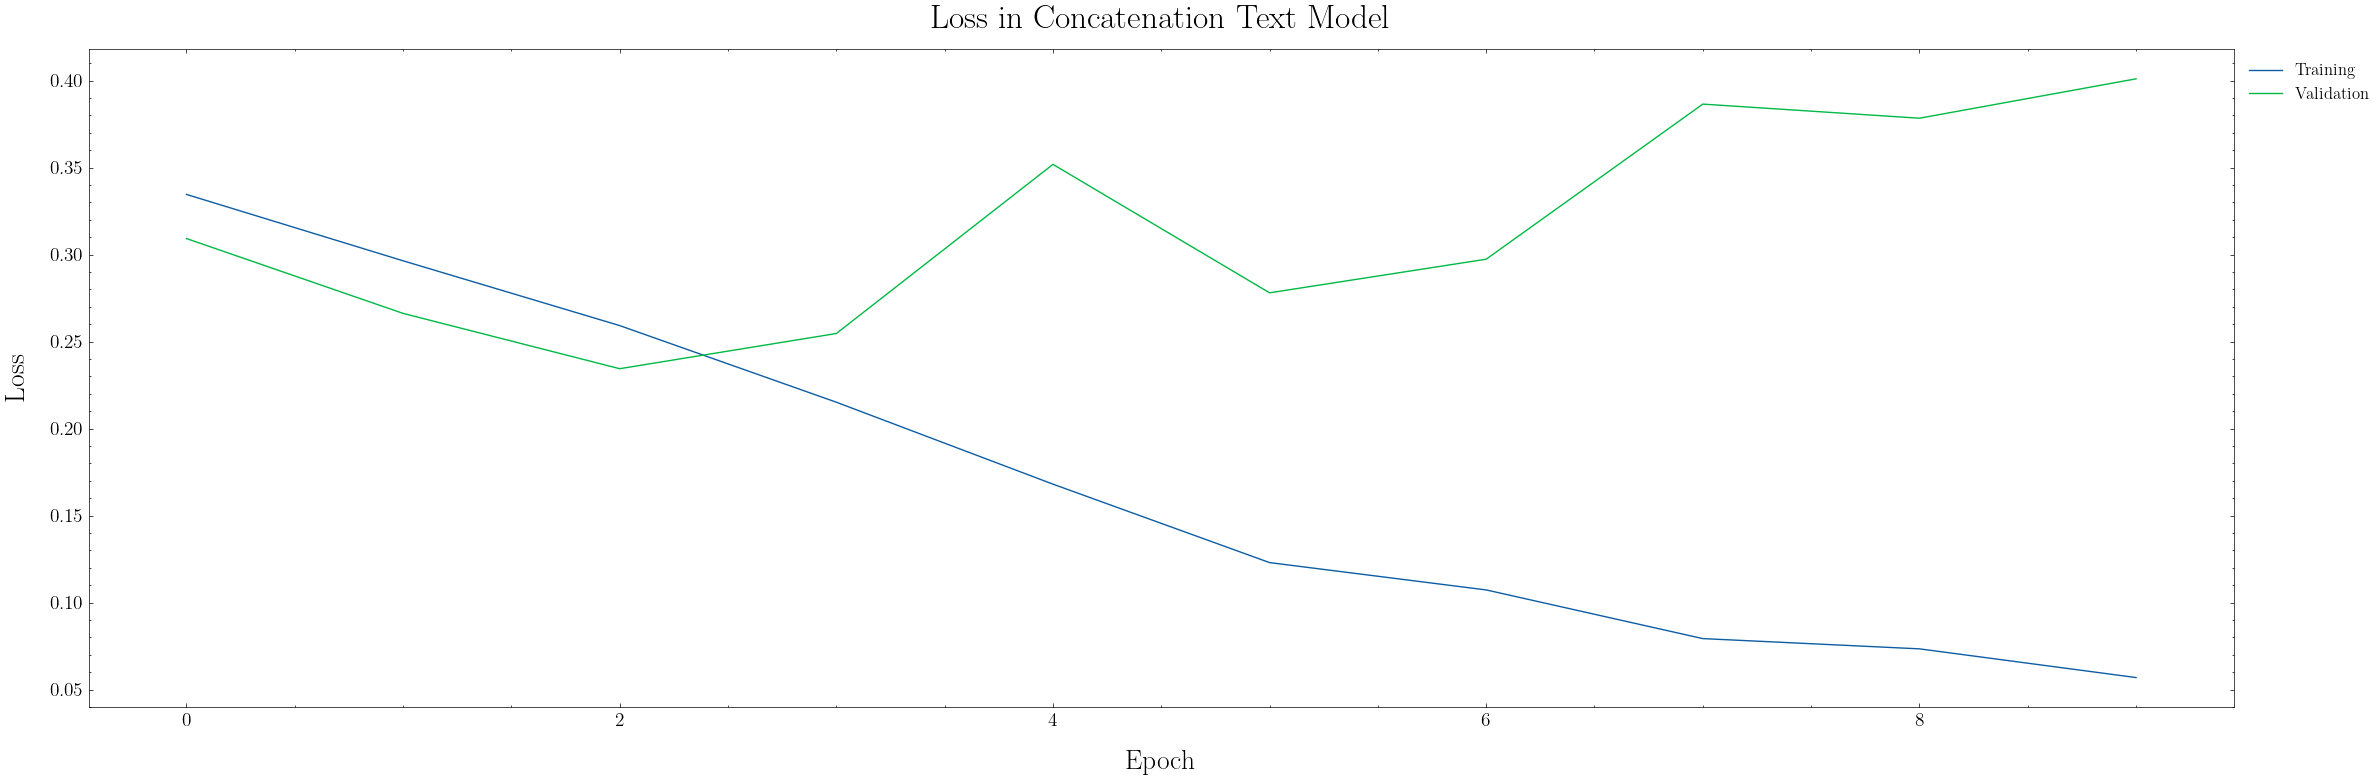

In [116]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history_concatenation.history['loss'],
    label='Training'
)

plt.plot(
    history_concatenation.history['val_loss'],
    label='Validation'
)

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax.set_title('Loss in Concatenation Text Model')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

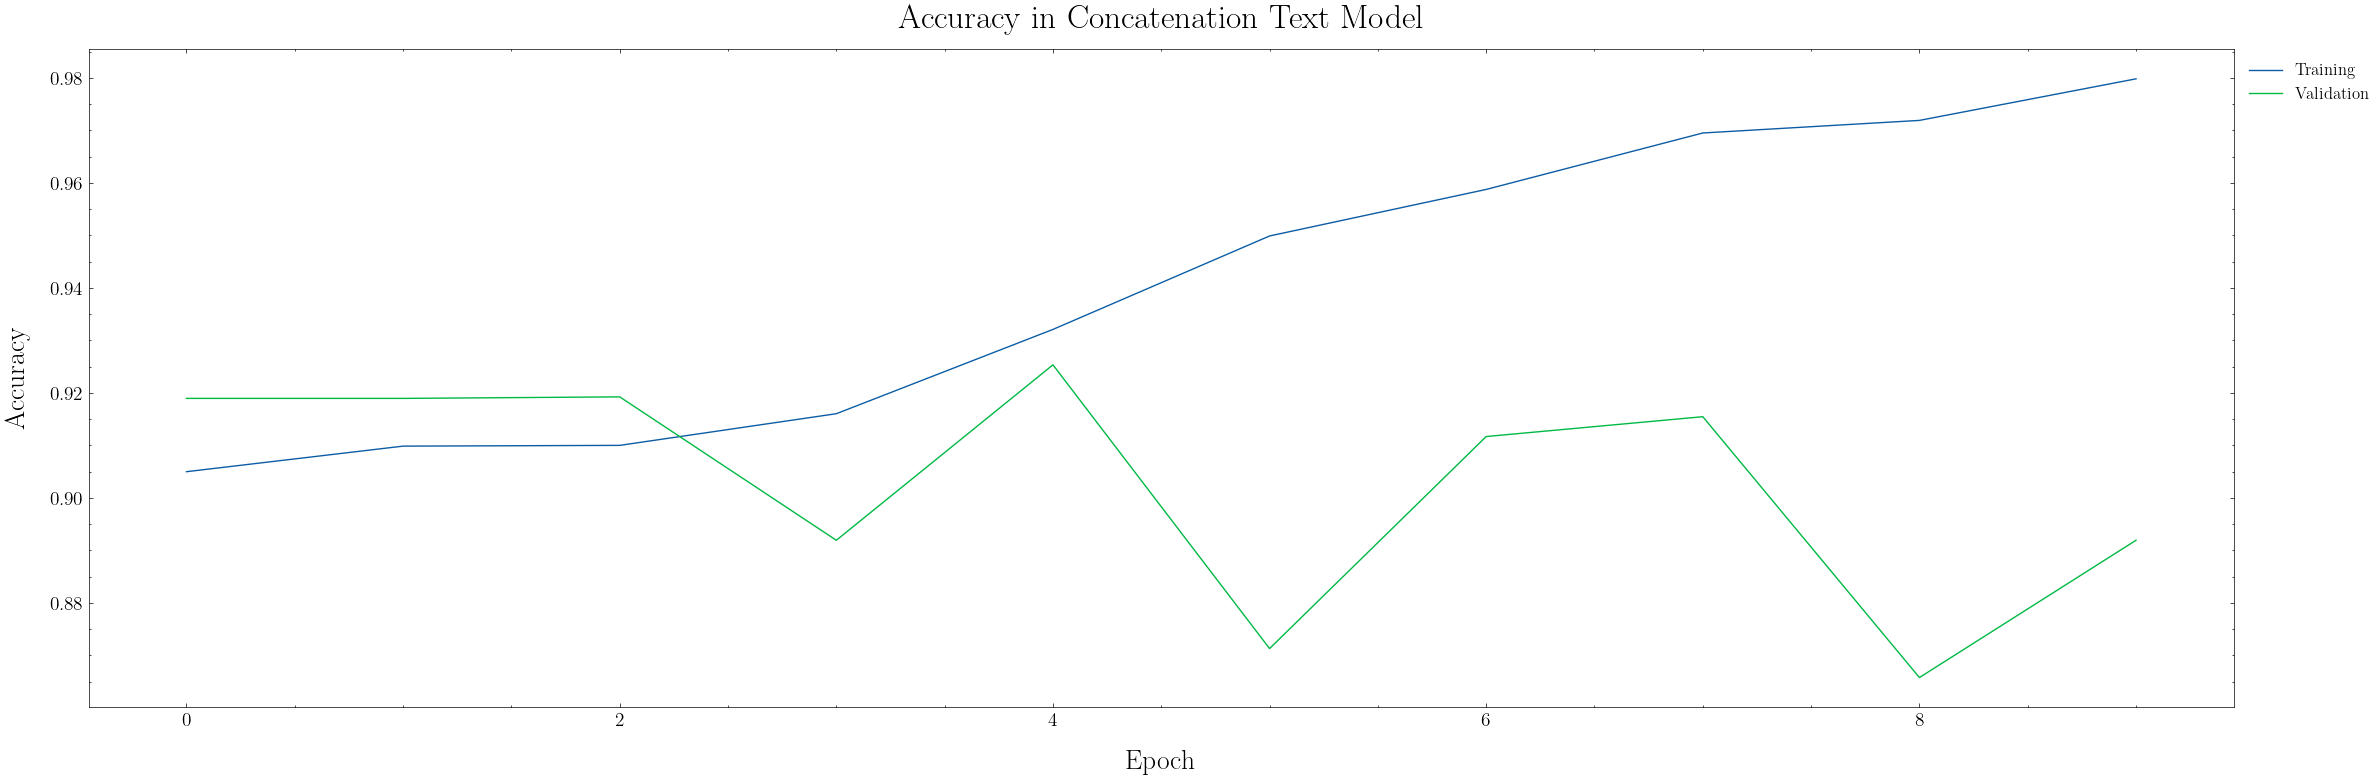

In [117]:
figsize = (24, 8)
fig, ax = plt.subplots(figsize=figsize)

plt.plot(
    history_concatenation.history['accuracy'],
    label='Training'
)

plt.plot(
    history_concatenation.history['val_accuracy'],
    label='Validation'
)

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

ax.set_title('Accuracy in Concatenation Text Model')

plt.legend(
    loc='upper left', 
    bbox_to_anchor=(1, 1)
)

plt.tight_layout()
plt.show()
plt.close()

$$\text{\Huge{Model testing}}$$

In [118]:
loss, accuracy = model_nw.evaluate(testing_dataset)
display_deep_score(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9685 - loss: 0.3593 


,Metric,Score
0,Loss,0.356873
1,Accuracy,0.972603


In [119]:
loss, accuracy = model_wo.evaluate(testing_dataset)
display_deep_score(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9746 - loss: 0.3524


,Metric,Score
0,Loss,0.351460
1,Accuracy,0.972603


In [120]:
loss, accuracy = model_pretrained.evaluate(testing_dataset)
display_deep_score(loss, accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9758 - loss: 0.4468


,Metric,Score
0,Loss,0.447381
1,Accuracy,0.972603


In [121]:
loss, accuracy = model_concatenation.evaluate(
    [X_test_title, X_test_content], y_test
)

display_deep_score(loss, accuracy)

135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8978 - loss: 0.4246


,Metric,Score
0,Loss,0.418476
1,Accuracy,0.895165


In [122]:
def lookup(path):
    template = {}

    review, album, occurrence = sample.stem.split('_')

    column = ['album', 'score']

    album = (
        df_review
        .loc[df_review['id'] == int(review), column]
        .values
    )

    item, *_ = album
    album, score = item

    score = round(
        Decimal(
            float(score)
        ),
        2
    )

    column = ['band', 'title', 'year']

    row = (
        df_album
        .loc[df_album['id'] == int(album), column]
        .values
    )

    item, *_ = row
    identifier, title, year = item

    band = (
        df_band
        .loc[df_band['id'] == int(identifier)]
    )

    name = band.name.to_string(index=False)

    template['name'] = name
    template['title'] = title
    template['year'] = year
    template['score'] = score
    template['path'] = path

    return template

In [123]:
def get_prediction(model, text):
    text = np.array([text], dtype='object')

    prediction = model.predict(
        np.array(
            [text]
        ),
        verbose=False
    )

    prediction, *_ = prediction
    prediction, *_ = prediction

    return round(
        Decimal(
            float(prediction)
        ),
        2
    )

In [124]:
def format_review(review):
    name = review.get('name')
    title = review.get('title')
    year = review.get('year')
    score = review.get('score')
    path = review.get('path')

    with open(path, 'r', encoding='utf-8') as handle:
        text = handle.read()

    text = text.encode('utf-8').decode('utf-8')
    
    prediction = get_prediction(model_wo, text)

    heading = f"{name} - {title} ({year})"

    display(
            Markdown(f"<h1><font color='#e06c75'><center>{heading}</center></font>"
        )
    )

    display(
        Markdown(f"<h2><font color='#61afef'><center><strong>Score:</strong> {score}</center></font></h2>")
    )

    display(
        Markdown(f"<h2><font color='#61afef'><center><strong>Probability of Review being Positive:</strong> {prediction}</center></font></h2>")
    )

    display(
        Markdown(f">{text}")
    )

In [125]:
samples = [
    file for file in validation_negative.iterdir()
]

sample = choice(samples)

band = lookup(sample)
format_review(band)

<h1><font color='#e06c75'><center>Alien Avenge - 第五太陽紀 / Tonatiuh (2010)</center></font>

<h2><font color='#61afef'><center><strong>Score:</strong> 0.47</center></font></h2>

<h2><font color='#61afef'><center><strong>Probability of Review being Positive:</strong> 0.33</center></font></h2>

>Alien Avenge is a strange Taiwanese band labeled as melodic death metal. The band is surely innovative, but is quite hard to digest. The band has so many different faces that it’s hard to get what the six musicians are actually trying to accomplish on their first record, Still, Tonatiuh performed surprisingly well in Asia, and even got some attention from European countries thanks to the recommendation and participation of Chthonic’s bassist Doris Yeh.To begin with, we have short and not very appealing instrumentals on this record, such as the disharmonic and almost random piano interlude “81025”. This interlude sounds like a missed attempt at creating a bastardized UneXpect and X Japan instrumental hybrid. I really can’t make any sense of a song like this. On the other hand, the band also comes around with one rather promising instrumental, “Ice”, featuring acoustic guitars and progressive keyboard sounds. This is the kind of music I would expect to hear on a new Opeth release, for example. Why are these instrumentals here? I have no clue, because they don’t have anything to do with, and don’t fit in with the rest of the record. They rather slow the record down instead of adding a well integrated new dimension to it. Maybe these songs were just quickly made to stretch and fill the record with more music, or maybe they’re here on purpose to mix us up just like the rest of this album. Maybe it's just me and I don’t get it.Other than that, we’ve got a few brutal, fast-paced modern extreme metal songs that are influenced by bands such as Children Of Bodom, In Flames, and Soilwork, but also something like Nevermore in the more atmospheric moments. Some tracks have an apocalyptic touch, such as “Revenge War” or “Melting”, featuring Chthonic’s bassist Doris Yeh, who performs some piercing screams on this song. Both tracks convince with their well-suited keyboard parts, gripping riffs, and well performed melodic guitar solos. The latter track even has a few slightly progressive transitions and is among the best pieces on here.Other tracks like “Torment” or “Hung War” are much more straightforward, and yet way too chaotic for me. The vocals in these tracks are somewhere between death and black metal styles, and could appeal to those who liked the last Sigh record, for example, or some songs made by Absu.There’s also an epic track called “Intrusion Collapse”, that approaches the ten minute mark. This is somewhat of a highlight amongst this record’s weirdness. The track starts promisingly, with epic keyboard sounds that make you expect a power metal track, but the song shifts to a melodic black metal anthem in the key of Chthonic or Dimmu Borgir, before it suddenly gets a clear death metal touch again. The mixture doesn’t work all too badly once you get used to it. But just before the five minute mark, the song seems to be over, and we get a few seconds of silence before a rather calm and atmospheric interlude leads us into an equally strange second part of the same track. These parts are clearly jazz influenced. At this point, I’m not surprised by anything anymore. Once you start to enjoy the calmer mood with atmospheric keyboards and great guitar melodies, the madness kicks off again and we get some blistering extreme metal. The entire track represents the record very well. The song is promising and has its moments. The technical abilities of the band are quite good, but I feel that nothing fits together well at all. Even after multiple spins, this song and record remain completely inaccessible to me, which doesn’t happen quite often with my preference for the experimental. I had less headaches watching David Lynch’s entire “Dumbland” series than listening to this record.In the end, this record is a truly confusing output. From addicting genre tracks to overwhelmingly chaotic songs, you get a whole bunch of more or less gripping variations of the melodic death metal genre. Short instrumentals and overlong tracks make this record very hard to digest. The album feels too ambitious, directionless, and totally overwhelming. Even the lyrics vary from Chinese to English from song to song without any apparent reason. The tracks don’t really fit together, and this record has no clear guiding line apart from its genre categorization. Even the songs themselves have parts that don’t fit together. We get sudden breaks in some tracks, and one thinks for sure that a new song has started, but according to the track labels, it’s still the same song, but has completely changed.Yes, this band has got some talent and they surely have loads of ideas, but they don’t manage to put them into consistent song writing. That’s why this record is rather frustrating and quite hard to sit through. I can only recommend this album to chaotic and destructive minds and die hard extreme metal fans that look to try out everything from this genre.Originally written for Black Wind Metal

$$\text{\Huge{Discussion}}$$

- There was no striking performance difference between the two models (word order vs. no word order)
- We managed to achieve over 90% accuracy on both
    - When our model was overfitting, we observed our training accuracy at 98-100% and the testing/validation accuracy at ~90%
    - After introducing `BatchNormalization` and `Dropout`, our training/testing/validation accuracy typically hovered around 93-94%
- However, we are aware that there is an imbalance in our dataset that we didn't address, which may have skewed our model
    - We were unsure how to tackle resampling when using `text_dataset_from_directory`
        - We assumed that we could have used `train_test_split` instead of `text_dataset_from_directory`
    - After examining our best model's predictive ability, we've observed that when it is wrong - it is confidently wrong.
        - This seemed particularly true when a review was negative, but the model predicted it to be a *highly* positive review
            - We attribute it to (or at least acknowledge the role of) the imbalance in our dataset